# DCGAN with attribute
## Architecture:
* <b>image size: (H, W): from (218, 178) to (32, 32)</b>
* <b>Generator:</b> 1 FC + 4 deconv layer <br>
    [**(data)**+**(attr)**] 
    -> [FC] -> flatten -> BN1 -> lReLU1  <br>
    ->[Decv2] -> BN2 -> lReLU2 <br>
    ->[Decv3] -> BN3 -> lReLU3 <br>
    ->[Decv4] -> sigmoid<br>
* <b>Discriminator:</b>4 conv layer + 1 FC layer <br>
    [**(data)**] 
    ->[Conv1] -> lReLU1 -> <br>
    ->[Conv2] -> BN2 -> lReLU2 <br>
    ->[Conv3] -> BN3 -> lReLU3 <br>
    ->flatten + **(attr)** -> [FC]<br>

In [77]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.misc
import pandas as pd
import os
import math
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

mb_size = 16
num_of_img = 10000
Z_dim = 100  # noize dim
X_dim = 116412 # 178 * 218 * 3
y_dim = 23 # total attr dim
h_dim = 128 # last FC hidden layer

H_ = 32 
W_ = 32 
attr_dim = 1 # desired sample attr dim

### det directory
OUTPUT_DIR = 'output_DCGAN_attr/' #'output_DCGAN_'+ str(epoch)+'_'+str(lr)+'/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data preprocessing
* helper function for risizee image
* load data & attr
* choose choose specific features for observation

In [78]:
################################### 
###    Old code    ###
'''

def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        # plt.imshow(sample.reshape(178, 218), cmap='Greys_r')
        plt.imshow(sample.reshape(218, 178, 3))

    return fig
'''
###     End of Old Code    ###
###################################

def center_crop(x, crop_h, crop_w,
                resize_h=64, resize_w=64):
    if crop_w is None:
        crop_w = crop_h
    h, w = x.shape[:2]
    j = int(round((h - crop_h)/2.))
    i = int(round((w - crop_w)/2.))
    return scipy.misc.imresize(
        x[j:j+crop_h, i:i+crop_w], [resize_h, resize_w])

def transform(image, input_height, input_width, 
              resize_height=64, resize_width=64, crop=True):
    if crop:
        cropped_image = center_crop(
          image, input_height, input_width, 
          resize_height, resize_width)
    else:
        cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
#     return np.array(cropped_image)/127.5 - 1.
    return np.array(cropped_image)/255.

In [79]:
def load_train_data():
    cols = ["Arched_Eyebrows", "Bags_Under_Eyes", "Bangs", "Big_Lips", "Big_Nose", "Black_Hair", "Blond_Hair", "Brown_Hair",
       "Bushy_Eyebrows","Eyeglasses","Heavy_Makeup","High_Cheekbones","Male", "Mouth_Slightly_Open","Narrow_Eyes",
       "No_Beard","Oval_Face","Pointy_Nose","Smiling","Straight_Hair","Wavy_Hair","Wearing_Hat","Young"]

    attr = pd.read_csv('data/list_attr_celeba.csv', delim_whitespace=True, skiprows=1, usecols=cols)

    attr = attr.values[:num_of_img]
    print "shape of attr: {}".format(attr.shape)
   
    X = []

    for i in xrange(num_of_img):
        X_ = scipy.misc.imread('data/img_align_celeba/{:06d}.jpg'.format(i + 1))
        X_ = transform(X_, 218, 178, H_, W_, True)
        X_ = X_.reshape(H_ * W_ * 3)
        #X_ = np.concatenate([X_, attr[i]])
        X.append(X_)

    X = np.array(X)
    
   
    print
    print "shape of one image: {}".format(X[0].shape)
    print "min of one image: {}".format(np.amin(X[0]))
    print "max of one image: {}".format(np.amax(X[0]))
    print "shape of X: {}".format(X.shape)
    
    return X, attr


shape of attr: (10000, 23)

shape of one image: (3072,)
min of one image: 0.0078431372549
max of one image: 0.996078431373
shape of X: (10000, 3072)
shape of one image: (32, 32, 3)
feature of the image: [-1]


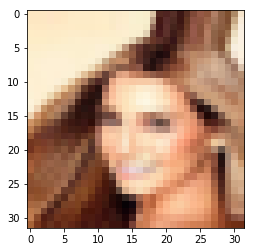

In [80]:
#####################################################################
###           choose specific features for observation            ###
#####################################################################
# features = [("Arched_Eyebrows", -1), ("Bags_Under_Eyes", -1), ("Bangs", 1), ("Big_Lips", -1), ("Big_Nose", -1),
#             ("Black_Hair", -1), ("Blond_Hair", 1), ("Brown_Hair", -1), ("Bushy_Eyebrows", -1), ("Eyeglasses", -1),
#             ("Heavy_Makeup", -1), ("High_Cheekbones", 1), ("Male", 1), ("Mouth_Slightly_Open", -1), ("Narrow_Eyes", 1),
#             ("No_Beard", -1), ("Oval_Face", 1), ("Pointy_Nose", -1), ("Smiling", 1), 
#             ("Straight_Hair", 1), ("Wavy_Hair", -1), ("Wearing_Hat", -1), ("Young", 1)]
# features = map(lambda x: x[1], features)

features = [1] # Male, 1

# store sample feature
sample_features = np.array(features).reshape((-1,1))

#####################################################################
###                        Load celeb data                        ###
#####################################################################
# (1) reshape date (2) select desired attributes
celeb_data, attr = load_train_data()
celeb_data = celeb_data.reshape((celeb_data.shape[0], H_, W_, 3))
desired_attr = attr[:,12] # index 12: Male

# store training data and attr
train_samples = celeb_data, desired_attr.reshape((-1,1))


# check training data and feature
print "shape of one image: {}".format(train_samples[0][0].shape)
print "feature of the image: {}".format(train_samples[1][0])
fig = plt.figure()   
plt.imshow(train_samples[0][0])

## Implement GAN

* (1) define layer function
* (2) DCGAN

In [81]:
def viz_grid(Xs, padding):
    N, H, W, C = Xs.shape
    grid_size = int(math.ceil(math.sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size + 1)
    grid_width = W * grid_size + padding * (grid_size + 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = padding, H + padding
    for y in range(grid_size):
        x0, x1 = padding, W + padding
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                grid[y0:y1, x0:x1] = img
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid

def conv2d(input, kernel_size, stride, num_filter, name = 'conv2d'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d(input, W, stride_shape, padding = 'SAME') + b

def conv2d_transpose(input, kernel_size, stride, num_filter, name = 'conv2d_transpose'):
    with tf.variable_scope(name):
        stride_shape = [1, stride, stride, 1]
        filter_shape = [kernel_size, kernel_size, num_filter, input.get_shape()[3]]
        output_shape = tf.stack([tf.shape(input)[0], tf.shape(input)[1] * 2, tf.shape(input)[2] * 2, num_filter])

        W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [1, 1, 1, num_filter], initializer = tf.constant_initializer(0.0))
        return tf.nn.conv2d_transpose(input, W, output_shape, stride_shape, padding = 'SAME') + b

def fc(input, num_output, name = 'fc'):
    with tf.variable_scope(name):
        num_input = input.get_shape()[1]
        W = tf.get_variable('w', [num_input, num_output], tf.float32, tf.random_normal_initializer(0.0, 0.02))
        b = tf.get_variable('b', [num_output], initializer = tf.constant_initializer(0.0))
        return tf.matmul(input, W) + b

def batch_norm(input, is_training):
    out = tf.contrib.layers.batch_norm(input, decay = 0.99, center = True, scale = True,
                                       is_training = is_training, updates_collections = None)
    return out

def leaky_relu(input, alpha = 0.2):
    return tf.maximum(alpha * input, input)

In [82]:
class DCGAN(object):

    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 32
        self.log_step = 50
        self.visualize_step = 200
        self.code_size = 100 #64
        self.attr_size = 1
        self.learning_rate = 1e-4
        self.vis_learning_rate = 1e-2
        self.recon_steps = 100
        self.actmax_steps = 100
        
        self._dis_called = False
        self._gen_called = False
    
        self.tracked_noise = np.random.normal(0, 1, [64, self.code_size])

        self.real_input = tf.placeholder(tf.float32, [None, H_, W_, 3])
        self.real_label = tf.placeholder(tf.float32, [None, 1])
        self.fake_label = tf.placeholder(tf.float32, [None, 1])
        self.noise = tf.placeholder(tf.float32, [None, self.code_size])
        self.attr = tf.placeholder(tf.float32, [None, self.attr_size])
        
        
        self.is_train = tf.placeholder(tf.bool)
        
        self.recon_sample = tf.placeholder(tf.float32, [1, 32, 32, 3])
        self.actmax_label = tf.placeholder(tf.float32, [1, 1])
        
        with tf.variable_scope('actmax'):
            self.actmax_attr = tf.placeholder(tf.float32, [1, self.attr_size])
#             tf.get_variable('actmax_code', [1, self.attr_size])
            self.actmax_code = tf.get_variable('actmax_code', [1, self.code_size],
                                               initializer = tf.constant_initializer(0.0))
        
        self._init_ops()

    def _discriminator(self, inputs, attr_):
        # We have multiple instances of the discriminator in the same computation graph,
        # so set variable sharing if this is not the first invocation of this function.
        with tf.variable_scope('dis', reuse = self._dis_called):
            self._dis_called = True
            dis_conv1 = conv2d(inputs, 4, 2, 32, 'conv1')
#             print dis_conv1.shape
            dis_lrelu1 = leaky_relu(dis_conv1)
            dis_conv2 = conv2d(dis_lrelu1, 4, 2, 64, 'conv2')
#             print dis_conv2.shape
            dis_batchnorm2 = batch_norm(dis_conv2, self.is_train)
            dis_lrelu2 = leaky_relu(dis_batchnorm2)
            dis_conv3 = conv2d(dis_lrelu2, 4, 2, 128, 'conv3')
#             print dis_conv3.shape
            dis_batchnorm3 = batch_norm(dis_conv3, self.is_train)
            dis_lrelu3 = leaky_relu(dis_batchnorm3)
            dis_reshape3 = tf.reshape(dis_lrelu3, [-1, 4 * 4 * 128])
#             print dis_reshape3.shape
            dis_addAttr3 = tf.concat([dis_reshape3, attr_], axis = 1)
            dis_fc4 = fc(dis_addAttr3, 1, 'fc4')
            return dis_fc4

    def _generator(self, noise, attr_):
        with tf.variable_scope('gen', reuse = self._gen_called):
            self._gen_called = True
            inputs = tf.concat(values = [noise, attr_], axis = 1)
            gen_fc1 = fc(inputs, 4 * 4 * 128, 'fc1')
            gen_reshape1 = tf.reshape(gen_fc1, [-1, 4, 4, 128])
#             print gen_reshape1.shape
            gen_batchnorm1 = batch_norm(gen_reshape1, self.is_train)
            gen_lrelu1 = leaky_relu(gen_batchnorm1)
            gen_conv2 = conv2d_transpose(gen_lrelu1, 4, 2, 64, 'conv2')
#             print gen_conv2.shape
            gen_batchnorm2 = batch_norm(gen_conv2, self.is_train)
            gen_lrelu2 = leaky_relu(gen_batchnorm2)
            gen_conv3 = conv2d_transpose(gen_lrelu2, 4, 2, 32, 'conv3')
#             print gen_conv3.shape
            gen_batchnorm3 = batch_norm(gen_conv3, self.is_train)
            gen_lrelu3 = leaky_relu(gen_batchnorm3)
            gen_conv4 = conv2d_transpose(gen_lrelu3, 4, 2, 3, 'conv4')
#             print gen_conv4.shape
            gen_sigmoid4 = tf.sigmoid(gen_conv4)
            return gen_sigmoid4

    def _loss(self, labels, logits):
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)

    def _reconstruction_loss(self, generated, target):
        loss = tf.nn.l2_loss(generated - target)
        return tf.reduce_mean(loss)
    
    # Define operations
    def _init_ops(self):
        
        ################################################################################
        # Prob 2-1: complete the definition of these operations                        #
        ################################################################################
        self.fake_samples_op = self._generator(self.noise, self.attr)
        D_fake = self._discriminator(self.fake_samples_op, self.attr)
        D_real = self._discriminator(self.real_input, self.attr)
        
        self.dis_loss_op = self._loss(self.real_label, D_real) + self._loss(self.fake_label, D_fake)
        self.gen_loss_op = self._loss(self.real_label, D_fake)
        
        ################################################################################
        # Prob 2-1: fix the definition of these operations                             #
        ################################################################################
        all_vars = tf.trainable_variables()

        d_var = [v for v in all_vars if v.name.startswith('dis')]
        g_var = [v for v in all_vars if v.name.startswith('gen')]
        
        # print the var status to check var
        import tensorflow.contrib.slim as slim
        print("********* d_var ********** ")
        slim.model_analyzer.analyze_vars(d_var, print_info=True)
        print("********* g_var ********** ") 
        slim.model_analyzer.analyze_vars(g_var, print_info=True)

        dis_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.dis_train_op = dis_optimizer.minimize(self.dis_loss_op, var_list = d_var)
        
        gen_optimizer = tf.train.RMSPropOptimizer(self.learning_rate)
        self.gen_train_op = gen_optimizer.minimize(self.gen_loss_op, var_list = g_var)
        
        ################################################################################
        # Prob 2-4: check the definition of these operations                           #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.actmax_sample_op = self._generator(self.actmax_code, self.actmax_attr)
        actmax_dis = self._discriminator(self.actmax_sample_op, self.actmax_attr)
        self.actmax_loss_op = self._loss(self.actmax_label, actmax_dis)

        actmax_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.actmax_op = actmax_optimizer.minimize(self.actmax_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        # Prob 2-4: complete the definition of these operations                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        self.recon_loss_op = self._reconstruction_loss(self.actmax_sample_op, self.recon_sample)
        
        recon_optimizer = tf.train.AdamOptimizer(self.vis_learning_rate)
        self.reconstruct_op = recon_optimizer.minimize(self.recon_loss_op, var_list = [self.actmax_code])
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################

    # Training function
    def train(self, sess, train_samples, sample_features):
        sess.run(tf.global_variables_initializer())
    
        train_data, train_attr= train_samples
        sample_features
        num_train = train_data.shape[0]
        step = 0
        
        # smooth the loss curve so that it does not fluctuate too much
        smooth_factor = 0.95
        plot_dis_s = 0
        plot_gen_s = 0
        plot_ws = 0
        
        dis_losses = []
        gen_losses = []
        for epoch in range(self.num_epoch):
            for i in range(num_train // self.batch_size):
                step += 1

                batch_data = train_data[i * self.batch_size : (i + 1) * self.batch_size]
                batch_attr = train_attr[i * self.batch_size : (i + 1) * self.batch_size]
                noise = np.random.normal(0, 1, [self.batch_size, self.code_size])
                zeros = np.zeros([self.batch_size, 1])
                ones = np.ones([self.batch_size, 1])
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                dis_feed_dict = {self.real_input: batch_data, 
                                 self.noise: noise, 
                                 self.attr: batch_attr,
                                 self.real_label: ones, 
                                 self.fake_label: zeros, 
                                 self.is_train:True}
        
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, dis_loss = sess.run([self.dis_train_op, self.dis_loss_op], feed_dict = dis_feed_dict)
        
                ################################################################################
                # Prob 2-1: complete the feed dictionary                                       #
                ################################################################################
                
                gen_feed_dict = {self.noise: noise, 
                                 self.attr: batch_attr,
                                 self.real_label: ones, 
                                 self.is_train: True}
        
                ################################################################################
                #                               END OF YOUR CODE                               #
                ################################################################################

                _, gen_loss = sess.run([self.gen_train_op, self.gen_loss_op], feed_dict = gen_feed_dict)

                plot_dis_s = plot_dis_s * smooth_factor + dis_loss * (1 - smooth_factor)
                plot_gen_s = plot_gen_s * smooth_factor + gen_loss * (1 - smooth_factor)
                plot_ws = plot_ws * smooth_factor + (1 - smooth_factor)
                dis_losses.append(plot_dis_s / plot_ws)
                gen_losses.append(plot_gen_s / plot_ws)

                if step % self.log_step == 0:
                    print('Iteration {0}: dis loss = {1:.4f}, gen loss = {2:.4f}'.format(step, dis_loss, gen_loss))

            if not os.path.exists(OUTPUT_DIR):
                os.mkdir(OUTPUT_DIR)
                
            filename = OUTPUT_DIR + '%d_%d.png' % (epoch,i)
            
            fig = plt.figure(figsize = (8, 8)) 
            ax1 = plt.subplot(111)
            image = viz_grid(self.generate(self.tracked_noise, sample_features), 1)
            scipy.misc.imsave(filename, image)
            ax1.imshow(image)
            plt.show()

            plt.plot(dis_losses)
            plt.title('discriminator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

            plt.plot(gen_losses)
            plt.title('generator loss')
            plt.xlabel('iterations')
            plt.ylabel('loss')
            plt.show()

    # Find the reconstruction of one input sample
    def reconstruct_one_sample(self, sample):
        
        ################################################################################
        # Prob 2-4: initialize self.actmax_code                                        #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        code = np.random.random([1, self.code_size])
        actmax_init_val = tf.convert_to_tensor(code, dtype = tf.float32)
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        sess.run(self.actmax_code.assign(actmax_init_val))
        last_reconstruction = None
        last_loss = None
        for i in range(self.recon_steps):
        
            ################################################################################
            # Prob 2-4: complete the feed dictionary                                       #
            # skip this part when working on problem 2-1 and come back for problem 2-4     #
            ################################################################################
                
            recon_feed_dict = {self.recon_sample: sample, 
                               self.is_train: False}
        
            ################################################################################
            #                               END OF YOUR CODE                               #
            ################################################################################
            
            run_ops = [self.recon_loss_op, self.reconstruct_op, self.actmax_sample_op]
            last_loss, _, last_reconstruction = sess.run(run_ops, feed_dict = recon_feed_dict)
        return last_loss, last_reconstruction

    # Find the reconstruction of a batch of samples
    def reconstruct(self, samples):
        reconstructions = np.zeros(samples.shape)
        total_loss = 0
        for i in range(samples.shape[0]):
            loss, reconstructions[i:i+1] = self.reconstruct_one_sample(samples[i:i+1])
            total_loss += loss
        return total_loss / samples.shape[0], reconstructions

    # Generates a single sample from input code
    def generate_one_sample(self, code, attr_):
        
        ################################################################################
        # Prob 2-1: complete the feed dictionary                                       #
        ################################################################################

        gen_vis_feed_dict = {self.noise: code, 
                             self.attr: attr_, 
                             self.is_train: False}
        
        ################################################################################
        #                               END OF YOUR CODE                               #
        ################################################################################
        
        generated = sess.run(self.fake_samples_op, feed_dict = gen_vis_feed_dict)
        return generated

    # Generates samples from input batch of codes
    def generate(self, codes, attr_):
        generated = np.zeros((codes.shape[0], H_, W_, 3))
        for i in range(codes.shape[0]):
            generated[i:i+1] = self.generate_one_sample(codes[i:i+1], attr_)
        return generated

    # Perform activation maximization on one initial code
    def actmax_one_sample(self, initial_code):
        
        ################################################################################
        # Prob 2-4: check this function                                                #
        # skip this part when working on problem 2-1 and come back for problem 2-4     #
        ################################################################################
        
        actmax_init_val = tf.convert_to_tensor(initial_code, dtype = tf.float32)
        sess.run(self.actmax_code.assign(actmax_init_val))
        for i in range(self.actmax_steps):
            actmax_feed_dict = {
                self.actmax_label: np.ones([1, 1]),
                self.is_train: False
            }
            _, last_actmax = sess.run([self.actmax_op, self.actmax_sample_op], feed_dict = actmax_feed_dict)
        return last_actmax

    # Perform activation maximization on a batch of different initial codes
    def actmax(self, initial_codes):
        actmax_results = np.zeros((initial_codes.shape[0], 32, 32, 3))
        for i in range(initial_codes.shape[0]):
            actmax_results[i:i+1] = self.actmax_one_sample(initial_codes[i:i+1])
        return actmax_results.clip(0, 1)

## Training
* start to train
* save the trained model at 'model/dcgan' 
* save output image & loss curve at OUTPUT_DIR


********* d_var ********** 
---------
Variables: name (type shape) [size]
---------
dis/conv1/w:0 (float32_ref 4x4x3x32) [1536, bytes: 6144]
dis/conv1/b:0 (float32_ref 1x1x1x32) [32, bytes: 128]
dis/conv2/w:0 (float32_ref 4x4x32x64) [32768, bytes: 131072]
dis/conv2/b:0 (float32_ref 1x1x1x64) [64, bytes: 256]
dis/BatchNorm/beta:0 (float32_ref 64) [64, bytes: 256]
dis/BatchNorm/gamma:0 (float32_ref 64) [64, bytes: 256]
dis/conv3/w:0 (float32_ref 4x4x64x128) [131072, bytes: 524288]
dis/conv3/b:0 (float32_ref 1x1x1x128) [128, bytes: 512]
dis/BatchNorm_1/beta:0 (float32_ref 128) [128, bytes: 512]
dis/BatchNorm_1/gamma:0 (float32_ref 128) [128, bytes: 512]
dis/fc4/w:0 (float32_ref 2049x1) [2049, bytes: 8196]
dis/fc4/b:0 (float32_ref 1) [1, bytes: 4]
Total size of variables: 168034
Total bytes of variables: 672136
********* g_var ********** 
---------
Variables: name (type shape) [size]
---------
gen/fc1/w:0 (float32_ref 101x2048) [206848, bytes: 827392]
gen/fc1/b:0 (float32_ref 2048) [2048, 

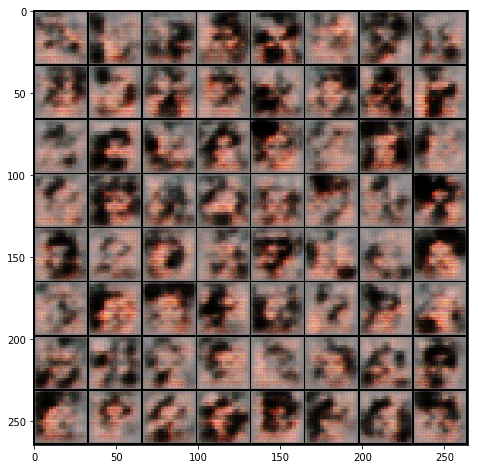

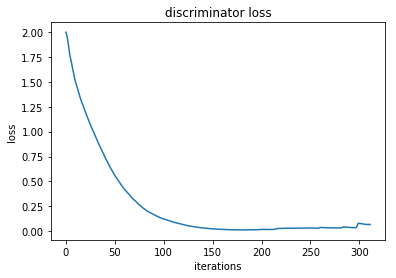

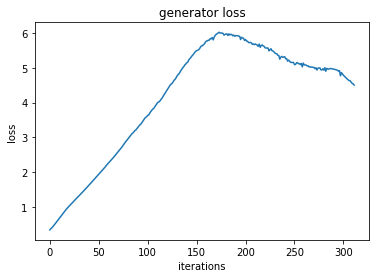

Iteration 350: dis loss = 0.1421, gen loss = 4.2174
Iteration 400: dis loss = 0.2145, gen loss = 3.4913
Iteration 450: dis loss = 0.3912, gen loss = 1.9921
Iteration 500: dis loss = 0.7616, gen loss = 2.6142
Iteration 550: dis loss = 0.5357, gen loss = 1.9724
Iteration 600: dis loss = 0.6232, gen loss = 2.0802


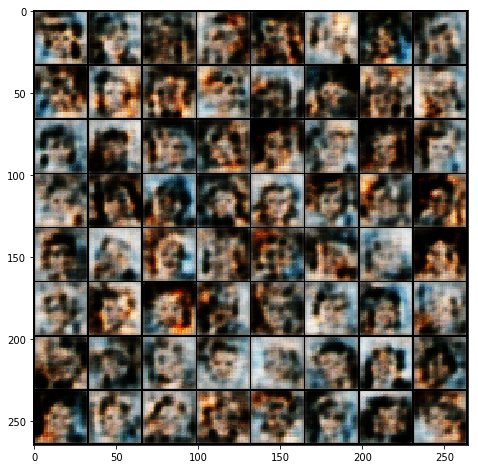

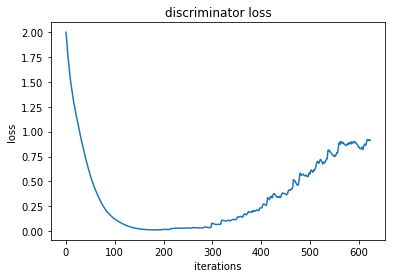

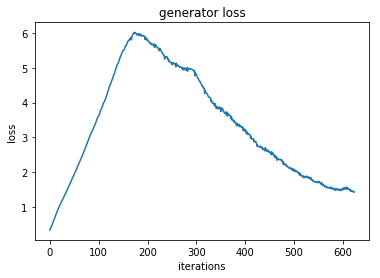

Iteration 650: dis loss = 0.9948, gen loss = 0.5689
Iteration 700: dis loss = 0.6910, gen loss = 1.4212
Iteration 750: dis loss = 0.6907, gen loss = 1.7377
Iteration 800: dis loss = 0.8695, gen loss = 0.8317
Iteration 850: dis loss = 0.4869, gen loss = 1.8905
Iteration 900: dis loss = 0.7692, gen loss = 1.1281


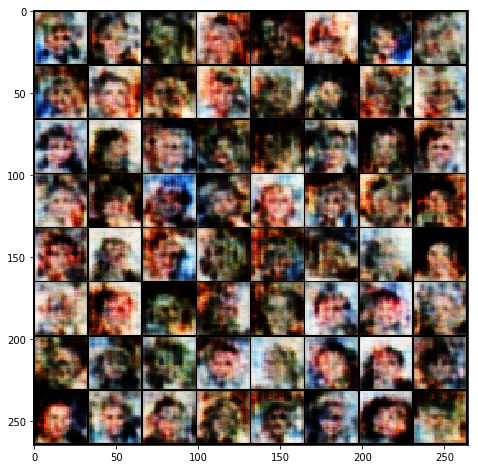

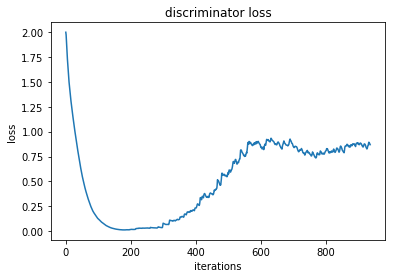

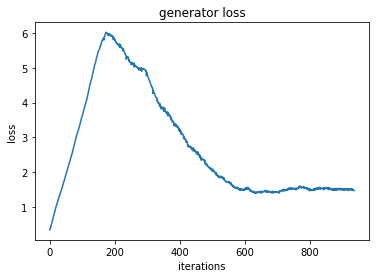

Iteration 950: dis loss = 0.7890, gen loss = 1.6376
Iteration 1000: dis loss = 0.8475, gen loss = 1.5528
Iteration 1050: dis loss = 0.8887, gen loss = 0.9538
Iteration 1100: dis loss = 1.1063, gen loss = 1.8431
Iteration 1150: dis loss = 1.3264, gen loss = 2.2131
Iteration 1200: dis loss = 1.2004, gen loss = 2.0060


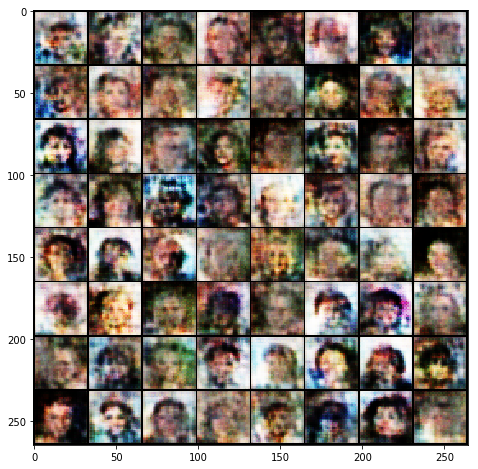

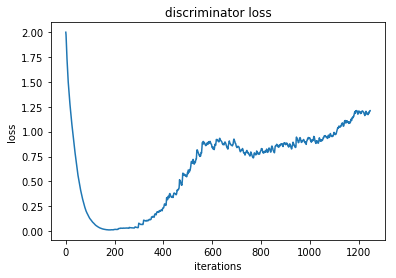

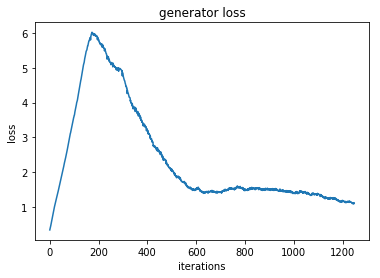

Iteration 1250: dis loss = 1.4636, gen loss = 0.6154
Iteration 1300: dis loss = 1.0787, gen loss = 1.0349
Iteration 1350: dis loss = 1.0423, gen loss = 1.2560
Iteration 1400: dis loss = 1.3056, gen loss = 1.3218
Iteration 1450: dis loss = 1.1398, gen loss = 0.7514
Iteration 1500: dis loss = 1.5186, gen loss = 0.8781
Iteration 1550: dis loss = 1.1586, gen loss = 1.0776


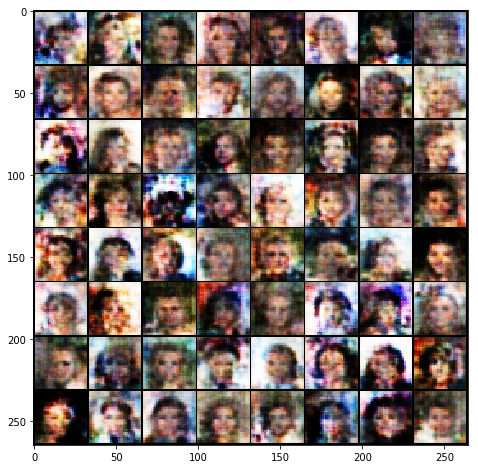

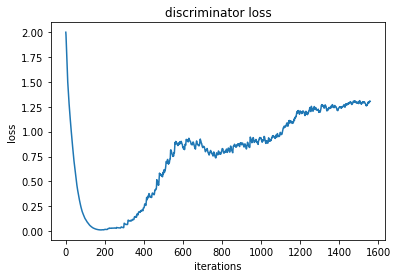

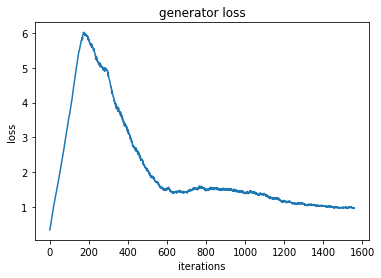

In [83]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dcgan.train(sess, train_samples, sample_features)
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.save(sess, 'model/dcgan')


## 2-4 Not modify yet
Activation Maximization is a visualization technique to see what a particular neuron has learned, by finding the input that maximizes the activation of that neuron. Here we use methods similar to *[Synthesizing the preferred inputs for neurons in neural networks via deep generator networks](https://arxiv.org/abs/1605.09304)*.

In short, what we want to do is to find the samples that the discriminator considers most real, among all possible outputs of the generator, which is to say, we want to find the codes (i.e. a point in the input space of the generator) from which the generated images, if labelled as real, would minimize the classification loss of the discriminator:

$$\min_{z} L(D_{\theta}(G_{\phi}(z)), 1)$$

Compare this to the objective when we were training the generator:

$$\min_{\phi} \mathrm{E}_{z \sim q(z)}[L(D_{\theta}(G_{\phi}(z)), 1)]$$

The function to minimize is the same, with the difference being that when training the network we fix a set of input data and find the optimal model parameters, while in activation maximization we fix the model parameters and find the optimal input.

So, similar to the training, we use gradient descent to solve for the optimal input. Starting from a random code drawn from a standard normal distribution, we perform a fixed step of Adam optimization algorithm on the code.

The batch normalization layers should work in evaluation mode.

We provide the code for this part, as a reference for solving the next part. You may want to go back to the code above and check the following:

*   **Build the computation graph for the loss:** Check the definition of these operations in ```_init_ops()```
    *   ```actmax_sample_op```: generate famples from ```actmax_code```
    *   ```actmax_loss_op```: compute discriminator's loss on samples generated from ```actmax_code```
*   **Define the optimizer:** Check the definition of ```actmax_op```, which updates ```actmax_code```
*   **Feed the data:** Check the function ```actmax_one_sample()```

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')
        actmax_results = dcgan.actmax(np.random.random([64, dcgan.code_size]))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(actmax_results, 1))
        plt.show()

The output should have less variety than those generated from random code. While it is reasonable that the samples that are "most real" makes up only a small portion of the sample space, this also gives us a hint that the so-called "mode collapse", in which the GAN simply fails to model a majority part of the data distribution, is a real problem.

A similar technique can be used to reconstruct a test sample, that is, to find the code that most closely approximates the test sample. To achieve this, we only need to change the loss function from discriminator's loss to the squared L2-distance between the generated image and the terget image:

$$\min_{z} \left|\left|G_{\phi}(z)-x\right|\right|_2^2$$

This time, we always start from a zero vector.

For this part, you need to complete code blocks marked with "Prob 2-4":

*   **Build the computation graph for the loss:** Complete the definition of ```recon_loss_op``` in ```_init_ops()```, which computes the squared L2-distance between ```recon_sample``` and the sample generated from ```actmax_code```.
*   **Define the optimizer:** Modify the definition of ```reconstruct_op``` so that it updates ```actmax_code``` rather than the parameters of the networks.
*   **Feed the data:** Set the proper initial value and feed the proper data in ```reconstruct_one_sample()```

In [ ]:
tf.reset_default_graph()

with tf.Session() as sess:
    with tf.device('/cpu:0'):
        dcgan = DCGAN()
        sess.run(tf.global_variables_initializer())
        dis_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'dis')
        gen_var_list = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'gen')
        saver = tf.train.Saver(dis_var_list + gen_var_list)
        saver.restore(sess, 'model/dcgan')

        avg_loss, reconstructions = dcgan.reconstruct(test_samples[64:128])
        print('average reconstruction loss = {0:.4f}'.format(avg_loss))
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(test_samples[64:128], 1))
        plt.show()
        fig = plt.figure(figsize = (8, 8))   
        ax1 = plt.subplot(111)
        ax1.imshow(viz_grid(reconstructions, 1))
        plt.show()

Now you can increase the training epochs. You should be able to achieve a reconstruction loss lower than 30.